## import library

In [1]:
import pandas as pd
import numpy as np
import re
import string
import joblib
# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# For vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Machine Learning Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC


# For combining sparse matrices
from scipy.sparse import hstack, csr_matrix
import bibtexparser

# Set random seed
RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenqiw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## load raw data

In [40]:
# csv data
#n indicate not related, y indicate related
ndata1 = pd.read_csv('author_papers_2022_2024_part_1.csv')
ydata1 = pd.read_csv('research_list_last.csv')
ydata2=pd.read_csv('Additional_Sustainability_Research_Papers.csv')
# bib data
with open('sus.bib') as bib_file:
    bib_database = bibtexparser.load(bib_file)
bib_entries = bib_database.entries
df = pd.DataFrame(bib_entries)
ydata3 = df[['abstract','title']]
#ndata = pd.concat([ndata1, ndata2,ndata3], ignore_index=True)
ndata=ndata1
ndata=ndata[['Title','Abstract']]
ndata.dropna(inplace=True, ignore_index= True)
ydata1=ydata1[['Research Title','Abstract']]
ydata1.dropna(inplace=True, ignore_index= True)
ydata2=ydata2[['RESEARCH TOPIC','ABSTRACT ']]
ydata2.dropna(inplace=True, ignore_index= True)
ndata.rename(columns={'Title':'title','Abstract':'abstract'},inplace=True)
ydata1.rename(columns={'Research Title':'title','Abstract':'abstract'},inplace=True)
ydata2.rename(columns={'RESEARCH TOPIC':'title','ABSTRACT ':'abstract'},inplace=True)
ydata = pd.concat([ydata1, ydata2,ydata3], ignore_index=True)
ndata['class']=0#not sustainablity
ydata['class']=1#sustainablity related
data = pd.concat([ydata, ndata], ignore_index=True)

In [43]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove whitespace
    text = text.strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    # Re-join tokens
    text = ' '.join(tokens)
    return text

In [44]:
tfidf_vectorizer_title = TfidfVectorizer(max_features=1000, ngram_range=(1,2))# change as needed
tfidf_vectorizer_abstract = TfidfVectorizer(max_features=1500, ngram_range=(1,2))

tfidf_matrix_title = tfidf_vectorizer_title.fit_transform(data['title'])
tfidf_matrix_abstract = tfidf_vectorizer_abstract.fit_transform(data['abstract'])

In [45]:
X = hstack([tfidf_matrix_title, tfidf_matrix_abstract])
y=data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [48]:
model= LogisticRegression(max_iter=100000, random_state=RANDOM_STATE)#,class_weight={0: 1, 1: 1}) #change class to balance flase negative/potive rt



In [49]:
model.fit(X_train,y_train)
#stacking_clf.fit(X_train,y_train)

LogisticRegression(max_iter=100000, random_state=42)

### test model

In [50]:
y_pred=model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9024390243902439
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87        67
           1       0.86      0.99      0.92        97

    accuracy                           0.90       164
   macro avg       0.92      0.88      0.89       164
weighted avg       0.91      0.90      0.90       164



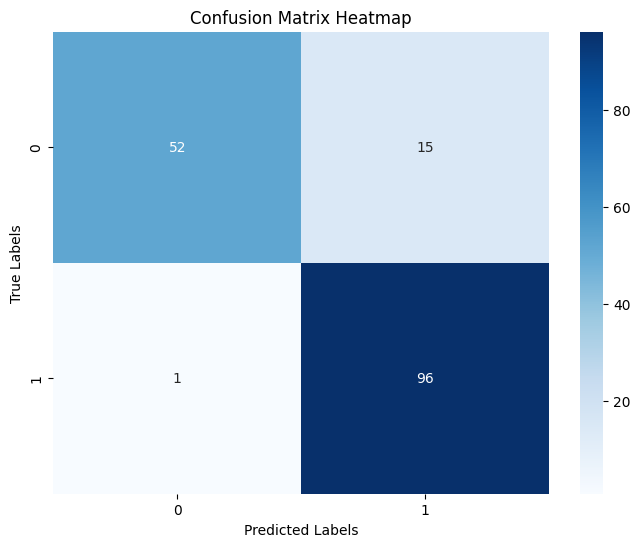

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heat map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## merge paper with department info

In [54]:
unclass_data = pd.read_csv('all_author_papers_2022_2024.csv')# load raw data
name_dep= pd.read_csv('name_dep.csv')# load department information
name_dep=name_dep[['uid','name','dep']]

In [55]:
def reformat_name(name):
    split_name = name.split(',')
    if len(split_name) == 2:
        last_name, first_name = split_name[0].strip(), split_name[1].strip()
        return f"{first_name} {last_name}"
    return name

# Reformat names
name_dep['Author'] = name_dep['name'].apply(reformat_name)
name_dep.head()# an example of how name_dep should look like

,uid,name,dep,Author
0,U00038784,"PARLA, AYSE",COLLEGE OF ARTS AND SCIS (CAS),AYSE PARLA
1,U99923945,"TIFFT, CHARLES P",SCHOOL OF MEDICINE (BUSM),CHARLES P TIFFT
2,U99512509,"SMITH-CROWE, KRISTIN",QUESTROM SCHOOL OF BUSINESS (QST),KRISTIN SMITH-CROWE
3,U99445757,"BETTINI, ELIZABETH",WHEELOCK COLLEGE OF EDUC & HUMAN DEVELOP,ELIZABETH BETTINI
4,U98974607,"WHITTY, ADRIAN",COLLEGE OF ARTS AND SCIS (CAS),ADRIAN WHITTY


In [22]:
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def preprocess_text(text):
    import re
    import string
    from nltk.corpus import stopwords
    from nltk.stem import SnowballStemmer

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove whitespace
    text = text.strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    # Re-join tokens
    text = ' '.join(tokens)
    return text

def predict_new_classes(new_data, tfidf_vectorizer_title, tfidf_vectorizer_abstract, model):
    # Handle missing values
    new_data['Title_p'] = new_data['Title'].fillna('').apply(preprocess_text)
    new_data['Abstract_p'] = new_data['Abstract'].fillna('').apply(preprocess_text)
    
    # Transform text
    tfidf_matrix_title = tfidf_vectorizer_title.transform(new_data['Title_p'])
    tfidf_matrix_abstract = tfidf_vectorizer_abstract.transform(new_data['Abstract_p'])
    
    # Combine title and abstract matrices
    X_new = hstack([tfidf_matrix_title, tfidf_matrix_abstract])
    
    # Predict classes
    predicted_classes = model.predict(X_new)
    
    # Add predictions to the DataFrame
    new_data['predicted_class'] = predicted_classes
    return new_data


# Assuming `new_data` is your new DataFrame with 'title' and 'abstract' columns
new_data = unclass_data

# Predict and add a new column
new_data_with_predictions = predict_new_classes(new_data, tfidf_vectorizer_title, tfidf_vectorizer_abstract, model)

# Show results
print(new_data_with_predictions)


                   Author                                              Title  \
0     KRISTIN SMITH-CROWE  A place in the world: Vulnerability, well-bein...   
1     KRISTIN SMITH-CROWE  The Relative Importance and Interaction of Con...   
2     KRISTIN SMITH-CROWE  Prompting and Punishing Transgressions: Interp...   
3       ELIZABETH BETTINI  Navigating the double bind: A systematic liter...   
4       ELIZABETH BETTINI  Burnout of special educators serving students ...   
...                   ...                                                ...   
7064       FABIO PETROCCA  When a Number Is Just a Number: Duffy-Null Blo...   
7065       FABIO PETROCCA  Updated clinical and correlative results from ...   
7066       FABIO PETROCCA  Febrile neutropenia in patients with Duffy-nul...   
7067       FABIO PETROCCA  OAB-007: Updated clinical and correlative resu...   
7068       FABIO PETROCCA  Anti-BCMA-CAR-T-Zell-Therapie bei einem Patien...   

                                       

In [26]:
new_data_with_predictions.predicted_class.value_counts()

predicted_class
0    6757
1     312
Name: count, dtype: int64

In [27]:
related_paper = new_data_with_predictions[new_data_with_predictions.predicted_class==1]
related_paper = related_paper[['Author','Title','Abstract','Year']]

In [28]:
output=related_paper.merge(name_dep, on='Author')

In [29]:
output.to_csv('gs_result_notcomplete.csv')